In [1]:
import os
import json
from mathutils import Matrix
import numpy as np
from scipy.spatial.transform import Rotation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [27]:
# Specify the path to the dataset folder
dataset_path = 'data/3RScan'

scenes = {}

for scan_folder in os.listdir(dataset_path):
    scan_folder_path = os.path.join(dataset_path, scan_folder)

    # Check if the folder contains semseg.v2.json file
    semseg_file = os.path.join(scan_folder_path, 'semseg.v2.json')
    if not os.path.isfile(semseg_file):
        continue

    # Read and parse the semseg.v2.json file
    with open(semseg_file, 'r') as file:
        semseg_data = json.load(file)

    scan_id = semseg_data['scan_id']
    seg_groups = semseg_data['segGroups']
    
    extracted_objects = []

    # Extract individual objects
    for object_data in seg_groups:
        obj = {}
        # Extract necessary data from JSON
        axes_lengths = object_data['obb']['axesLengths']
        centroid = object_data['obb']['centroid']
        normalized_axes = object_data['obb']['normalizedAxes']
        rotation_matrix = np.transpose(np.array(normalized_axes).reshape(3, 3))
        
        ##########################
        desired_normal = np.array([1/np.sqrt(2), 1/np.sqrt(2), 0])
        current_normal = object_data['dominantNormal']
        
        # ensure that dominant normal is the last vector of the rotation matrix
        if np.all(rotation_matrix[:, 0] == current_normal):
            rotation_matrix[:, 0] = rotation_matrix[:, 2]
            rotation_matrix[:, 2] = current_normal
            vector_1 = axes_lengths[0]
            vector_2 = axes_lengths[2]
            axes_lengths[0] = vector_2
            axes_lengths[2] = vector_1
        elif np.all(rotation_matrix[:, 1] == current_normal):
            rotation_matrix[:, 1] = rotation_matrix[:, 2]
            rotation_matrix[:, 2] = current_normal
            vector_1 = axes_lengths[1]
            vector_2 = axes_lengths[2]
            axes_lengths[1] = vector_2
            axes_lengths[2] = vector_1
        
        # compute rotation matrix from dominant normal to reference normal
        # Step 1: Calculate the rotation axis
        rotation_axis = np.cross(current_normal, desired_normal)
    
        # Step 2: Calculate the rotation angle
        dot_product = np.dot(current_normal, desired_normal)
        rotation_angle = np.arccos(dot_product)

        # Step 3: Create the rotation matrix
        rotation_matrix_2 = np.array([
            [0, -rotation_axis[2], rotation_axis[1]],
            [rotation_axis[2], 0, -rotation_axis[0]],
            [-rotation_axis[1], rotation_axis[0], 0]
        ]) + np.outer(rotation_axis, rotation_axis) * (1 - np.cos(rotation_angle))

        # Step 4: Apply the normalized axes
        #rotation_matrix = np.dot(rotation_matrix_2, rotation_matrix)
        
        ######################
        
        
        rotation = Rotation.from_matrix(rotation_matrix)
        euler_angles = rotation.as_euler('xyz', degrees=False) # degrees in radians
        #quaternion = rotation.as_quat()
        
        # for specific visualizations
        #if (object_data['label'] != 'sofa') and (object_data['label'] != 'wall') and (object_data['label'] != 'tv') and (object_data['label'] != 'commode') and (object_data['label'] != 'table') and (object_data['label'] != 'beanbag') and (object_data['label'] != 'light'):
            #continue
            
        # faking it
        #comparison_angles = [0.698, 2.269]
        #differences = np.abs(euler_angles[2] - comparison_angles)
        #closest_index = np.argmin(differences)
        #euler_angles[2] = comparison_angles[closest_index]
        
        # Print the extracted data for each object
        print("Object ID:", object_data['objectId'])
        obj['id'] = object_data['objectId']
        print("Label:", object_data['label'])
        obj['label'] = object_data['label']
        print("Location:", centroid)
        obj['location'] = centroid
        print("Size:", axes_lengths)
        obj['size'] = axes_lengths
        print("Euler Angles:", np.round(euler_angles))
        obj['euler_angles'] = euler_angles
        obj['rotation_matrix'] = rotation_matrix
        print(np.round(rotation_matrix, 2))
        print(np.round(object_data['dominantNormal'], 2))
        #print("Quaternion:", quaternion)
        #obj['quaternion'] = quaternion
        
        if np.all(np.round(object_data['dominantNormal']) == np.array([0, -0, 1])):
            obj['dominantNormal'] = 1
        else:
            obj['dominantNormal'] = 0
                
        
        print(obj['dominantNormal'])
        
        print("---")

        extracted_objects.append(obj)
    
    scenes[scan_id] = extracted_objects

Object ID: 14
Label: wall
Location: [-0.5973530983700146, -2.555398581097461, 0.2100500473368907]
Size: [4.43563043578445, 3.2909999350234864, 0.214380383343314]
Euler Angles: [2. 0. 2.]
[[-0.7   0.    0.72]
 [ 0.72 -0.    0.7 ]
 [ 0.    1.    0.  ]]
[0.72 0.7  0.  ]
0
---
Object ID: 27
Label: plant
Location: [0.7632876486718007, -3.4580537226543733, -0.820929503345574]
Size: [1.5918959532736994, 1.53071979496876, 1.228481026847339]
Euler Angles: [-0. -0. -3.]
[[-0.11  0.99  0.  ]
 [ 0.99  0.11 -0.  ]
 [ 0.    0.    1.  ]]
[ 0. -0.  1.]
1
---
Object ID: 4
Label: windowsill
Location: [-1.1800058887291685, 0.5172971928846, -0.6096214757944305]
Size: [3.6497809745206014, 0.8072537431597383, 0.520757007879979]
Euler Angles: [-0.  0. -3.]
[[ 0.67  0.74  0.  ]
 [ 0.74 -0.67 -0.  ]
 [ 0.   -0.    1.  ]]
[ 0. -0.  1.]
1
---
Object ID: 10
Label: shades
Location: [-0.7376044179106434, 1.3583551495191042, 0.3739544721553969]
Size: [1.9356489876150313, 1.7643309437260557, 0.5290871141518507]
Euler

beanbag
[0.5997799877438748, 0.5527398790134452, 0.31296002165317455]
[-0.6848079296041452, 1.5060081390575326, -1.4335199702719592]
-----
beanbag
[0.6293638243077344, 0.5521590436405068, 0.2655399978412687]
[0.0004288662035558666, 2.8715039234122988, -1.4627999168983852]
-----
table
[1.2866018825440841, 0.9381903362544737, 0.36407004973135776]
[0.1591025387698044, 1.3016003902726907, -1.4081149215157707]
-----
cushion
[1.1428079028868954, 0.6740807257823886, 0.32180999990232273]
[-1.0551514555732986, 0.1730843497361203, -1.1909049315778542]
-----
sofa
[3.7669858801493676, 2.318331065877849, 0.7811799470816562]
[0.37000782892721185, 0.4243664447198421, -1.220589921558798]
-----
ceiling
[5.0124928588894475, 4.558887293370877, 0.2000000432133664]
[0.4525370667924168, 1.9184919359604593, 1.6299999755390737]
-----
plant
[1.6083780500186295, 1.5077736724229778, 1.219999971538782]
[2.4499253481858627, 1.9043400135116695, -1.0199999562881141]
-----
light
[1.6959109766624176, 0.290299428327710

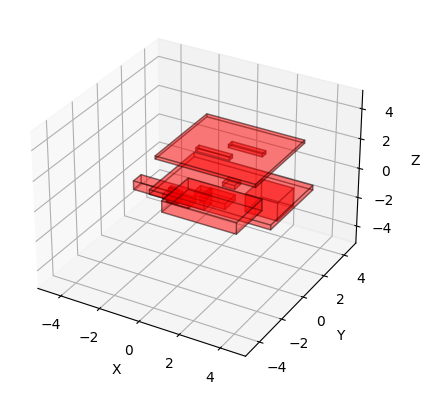

In [30]:
# Create a 3D plot
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')

i = 0

# Visualize objects in the scene
for object_data in scenes['4acaebcc-6c10-2a2a-858b-29c7e4fb410d']:
#for object_data in scenes['754e884c-ea24-2175-8b34-cead19d4198d']:
    # Extract necessary data from the object
    location = object_data['location']
    size = object_data['size']
    euler_angles = object_data['euler_angles']
    #quaternion = object_data['quaternion']
    
   
    
    i = i+1
    if object_data['dominantNormal'] == 0: 
        continue
    elif object_data['dominantNormal'] == 1 and i <25:
    #if i <20:   
        print(object_data['label'])
        print(size)
        print(location)
        print('-----')
    else:
        break
    
    rotation = Rotation.from_euler('xyz', euler_angles)
    rotation_matrix = rotation.as_matrix()
        

    # Compute half-lengths along each axis
    half_lengths = np.array(size) / 2

    # Define relative coordinates of object's corners in local frame
    corners = np.array([
        [-1, -1, -1],  # Corner 1
        [-1, -1, 1],   # Corner 2
        [-1, 1, -1],   # Corner 3
        [-1, 1, 1],    # Corner 4
        [1, -1, -1],   # Corner 5
        [1, -1, 1],    # Corner 6
        [1, 1, -1],    # Corner 7
        [1, 1, 1]      # Corner 8
    ])
    scaled_corners = corners * half_lengths
    #relative_corners = np.transpose(corners * half_lengths)
    relative_corners = np.transpose(scaled_corners)

    relative_corners_4 = np.vstack((relative_corners, np.ones(relative_corners.shape[1])))


    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = location

    global_corners_4 = np.matmul(transformation_matrix, relative_corners_4)
    global_corners = np.transpose(global_corners_4[:3, :])
    
    polygons = [
        [global_corners[0], global_corners[1], global_corners[3], global_corners[2]],
        [global_corners[4], global_corners[5], global_corners[7], global_corners[6]],
        [global_corners[0], global_corners[1], global_corners[5], global_corners[4]],
        [global_corners[2], global_corners[3], global_corners[7], global_corners[6]],
        [global_corners[0], global_corners[2], global_corners[6], global_corners[4]],
        [global_corners[1], global_corners[3], global_corners[7], global_corners[5]]
    ]
    
    # Create the 3D collection and add it to the plot
    collection = Poly3DCollection(polygons, alpha=0.3, facecolor='red', edgecolor='black')
    ax.add_collection3d(collection)
    

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits of the plot's axes
factor = 5
x_min, x_max, y_min, y_max, z_min, z_max = -factor, factor, -factor, factor, -factor, factor
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

# Show the plot
plt.show()

# leider spiegelverkehrt?

In [86]:
normalized_axes = np.array([1, 0, 0, 0, 1/np.sqrt(2), 1/np.sqrt(2), 0, -1/np.sqrt(2), 1/np.sqrt(2)])
rotation_matrix = np.transpose(np.array(normalized_axes).reshape(3, 3))
rotation = Rotation.from_matrix(rotation_matrix)
euler_angles = rotation.as_euler('xyz', degrees=False)
print(rotation_matrix)
print(euler_angles)

location = np.array([10, 10, 10])
size = np.array([4, 10, 8])

rotation = Rotation.from_euler('xyz', euler_angles)
rotation_matrix = rotation.as_matrix()
print(rotation_matrix)


# Compute half-lengths along each axis
half_lengths = np.array(size) / 2

# Define relative coordinates of object's corners in local frame
corners = np.array([
    [-1, -1, -1],  # Corner 1
    [-1, -1, 1],   # Corner 2
    [-1, 1, -1],   # Corner 3
    [-1, 1, 1],    # Corner 4
    [1, -1, -1],   # Corner 5
    [1, -1, 1],    # Corner 6
    [1, 1, -1],    # Corner 7
    [1, 1, 1]      # Corner 8
])
scaled_corners = corners * half_lengths
#relative_corners = np.transpose(corners * half_lengths)
relative_corners = np.transpose(scaled_corners)

relative_corners_4 = np.vstack((relative_corners, np.ones(relative_corners.shape[1])))

transformation_matrix = np.eye(4)
transformation_matrix[:3, :3] = rotation_matrix
transformation_matrix[:3, 3] = location

global_corners_4 = np.matmul(transformation_matrix, relative_corners_4)
global_corners = np.transpose(global_corners_4[:3, :])
print(global_corners)
    

[[ 1.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678]
 [ 0.          0.70710678  0.70710678]]
[0.78539816 0.         0.        ]
[[ 1.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678]
 [ 0.          0.70710678  0.70710678]]
[[ 8.          9.29289322  3.63603897]
 [ 8.          3.63603897  9.29289322]
 [ 8.         16.36396103 10.70710678]
 [ 8.         10.70710678 16.36396103]
 [12.          9.29289322  3.63603897]
 [12.          3.63603897  9.29289322]
 [12.         16.36396103 10.70710678]
 [12.         10.70710678 16.36396103]]


In [ ]:
euler_1 = np.array([90, 0, -40])
euler_2 = np.array([90, 0, 140])

rotation_1 = Rotation.from_euler('xyz', euler_1)
rotation_matrix_1 = rotation_1.as_matrix()

rotation_2 = Rotation.from_euler('xyz', euler_2)
rotation_matrix_2 = rotation_2.as_matrix()

vector = np.array([1, 2, 3])

print(np.matmul(rotation_matrix_1, vector))
print(np.matmul(rotation_matrix_2, vector))

In [8]:
rotation_matrix = np.array([[ 0.84,  0.,    0.54], [ 0.54, -0.,   -0.84], [ 0.,    1.,   -0.  ]])
current_normal = [ 0., -0.,  1.]

desired_normal = np.array([1/np.sqrt(2), 1/np.sqrt(2), 0])
#current_normal = object_data['dominantNormal']

if np.all(rotation_matrix[:, 0] == current_normal):
    rotation_matrix[:, 0] = rotation_matrix[:, 2]
    rotation_matrix[:, 2] = current_normal
elif np.all(rotation_matrix[:, 1] == current_normal):
    rotation_matrix[:, 1] = rotation_matrix[:, 2]
    rotation_matrix[:, 2] = current_normal

# compute rotation matrix from dominant normal to reference normal
# Step 1: Calculate the rotation axis
rotation_axis = np.cross(current_normal, desired_normal)

# Step 2: Calculate the rotation angle
dot_product = np.dot(current_normal, desired_normal)
rotation_angle = np.arccos(dot_product)

# Step 3: Create the rotation matrix
rotation_matrix_2 = np.array([
    [0, -rotation_axis[2], rotation_axis[1]],
    [rotation_axis[2], 0, -rotation_axis[0]],
    [-rotation_axis[1], rotation_axis[0], 0]
]) + np.outer(rotation_axis, rotation_axis) * (1 - np.cos(rotation_angle))

# Step 4: Apply the normalized axes
normalized_axes = np.dot(rotation_matrix_2, rotation_matrix)
print(normalized_axes)

[[ 0.15        0.69        0.70710678]
 [-0.15       -0.69        0.70710678]
 [-0.97580736  0.21213203  0.        ]]
